In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
from pathlib import Path
from ema_pytorch import EMA
from datetime import datetime
from utils.sim_utils import *
from utils.eval_utils import *
from utils.train_utils import *
from utils.couzin_utils import *
from utils.vec_sim_utils import *
from utils.encoder_utils import *
from geomloss import SamplesLoss
from utils.mmd_loss import MMDLoss
from models.Generator import ModularPolicy
from models.Discriminator import Discriminator

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
# Expert
max_steps = 500

# Training
num_generations = 1000
gamma = 0.999
deterministic=False # BC pretrain

# Policy
lr_policy = 5e-4
num_perturbations = 64
sigma = 0.1

# Discriminator
dis_balance_factor = 2
noise = 0.005
lr_disc = 5e-4
lambda_gp = 5

performance_eval = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Env Settings
height = 50
width = 50
prey_speed = 5
pred_speed = 5
step_size = 0.5
theta_dot_max = 0.5
max_turn = float(theta_dot_max * step_size) + 1e-12

pert_steps = 100
init_steps = 500

env_settings = (height, width, prey_speed, pred_speed, step_size, max_turn, pert_steps)

In [3]:
def sliding_window(tensor, window_size=10):
    sequences = []
    for start in range(0, tensor.size(0) - window_size + 1):
        end = start + window_size
        sequences.append(tensor[start:end])
    return torch.stack(sequences)

In [4]:
%matplotlib tk
_, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(
                                        visualization="off", 
                                        max_steps=init_steps, 
                                         constant_speed=prey_speed, shark_speed=pred_speed, 
                                         area_width=width, area_height=height,
                                         dt = step_size,
                                         alpha=0.01,
                                         theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                         number_of_sharks=0, n=32)

exp_prey_sequence = exp_prey_sequence.to(device)
init_pool = init_pool.to(device)

exp_prey_tensor = sliding_window(exp_prey_sequence, window_size=10)

print("Prey Tensor Shape:", exp_prey_sequence.shape)

Prey Tensor Shape: torch.Size([500, 32, 31, 5])


In [5]:
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)
prey_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=1200, optimizer=prey_optimizer, role="prey")

for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

epoch 010: loss=23.327986 sim=0.0620 std=1.3341 cov=0.3536 std_mean=0.333
epoch 020: loss=22.274817 sim=0.0472 std=1.2885 cov=0.3533 std_mean=0.356
epoch 030: loss=22.157684 sim=0.0525 std=1.2512 cov=0.4154 std_mean=0.374
epoch 040: loss=21.560778 sim=0.0531 std=1.2049 cov=0.4321 std_mean=0.398
epoch 050: loss=21.127413 sim=0.0515 std=1.1659 cov=0.4703 std_mean=0.417
epoch 060: loss=20.851738 sim=0.0463 std=1.1355 cov=0.5324 std_mean=0.432
epoch 070: loss=20.905991 sim=0.0555 std=1.1182 cov=0.5490 std_mean=0.441
epoch 080: loss=21.005304 sim=0.0530 std=1.1118 cov=0.6005 std_mean=0.444
epoch 090: loss=20.654324 sim=0.0510 std=1.1091 cov=0.5484 std_mean=0.445
epoch 100: loss=20.689331 sim=0.0485 std=1.1263 cov=0.5166 std_mean=0.437
epoch 110: loss=20.787231 sim=0.0497 std=1.1183 cov=0.5542 std_mean=0.441
epoch 120: loss=20.513432 sim=0.0460 std=1.1126 cov=0.5350 std_mean=0.444
epoch 130: loss=20.613163 sim=0.0498 std=1.1153 cov=0.5277 std_mean=0.442
epoch 140: loss=20.578516 sim=0.0507 s

In [6]:
%matplotlib inline
prey_policy = ModularPolicy(features=4).to(device)
prey_policy.set_parameters()
#pretrain_policy(prey_policy, role="prey", expert_data=exp_prey_tensor, batch_size=4048, epochs=500, lr=1e-3, deterministic=deterministic, device=device)
ema_prey = EMA(prey_policy, beta=0.9999, update_after_step=10, update_every=5, allow_different_devices=True)
print("Prey Policy pretrained.\n")

Prey Policy pretrained.



In [7]:
prey_mmd_loss = MMDLoss(encoder=prey_encoder, role="prey").to(device)
prey_discriminator = Discriminator(encoder=prey_encoder, role="prey", z_dim=32).to(device)
prey_discriminator.set_parameters(init=True)
optim_disc_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

sinkhorn_loss = SamplesLoss(loss="sinkhorn", backend="tensorized")

In [8]:
metrics_list = []
policy_metrics_list = []
disc_metrics_list = []

for gen in range(num_generations):
    rollout_prey_policy = ema_prey.ema_model.to("cuda")
    
    gen_pred_tensor, gen_prey_tensor = run_env_vectorized(prey_policy=rollout_prey_policy, 
                                                          pred_policy=None, 
                                                          n_prey=32, n_pred=0, 
                                                          step_size=step_size, max_steps=init_steps,
                                                          prey_speed=prey_speed, pred_speed=pred_speed, 
                                                          area_width=width, area_height=height, 
                                                          max_turn=max_turn,
                                                          init_pool=init_pool)

    for i in range(dis_balance_factor):
        # Prey Discriminator Update
        expert_prey_batch = sample_data(exp_prey_tensor, batch_size=10, window_len=10).to(device)
        generative_prey_batch = sample_data(gen_prey_tensor, batch_size=10, window_len=10).to(device)

        dis_metric_prey = prey_discriminator.update(expert_prey_batch, generative_prey_batch, optim_disc_prey, 
                                                    lambda_gp, noise=noise, generation=gen, num_generations=num_generations)
        
        disc_metrics_list.append((dis_metric_prey, None))
        
    # Predator Policy Update
    init_pos = init_positions(init_pool, batch=num_perturbations, mode="dual")

    # Prey Policy Update
    pin_prey_metrics = optimize_es(pred_policy=None, prey_policy=prey_policy,
                                   role="prey", module="pairwise", mode="mean", 
                                   discriminator=prey_discriminator, lr=lr_policy, sigma=sigma, 
                                   num_perturbations=num_perturbations, init_pos=init_pos, 
                                   settings_batch_env=env_settings)
    
    an_prey_metrics  = optimize_es(pred_policy=None, prey_policy=prey_policy,
                                   role="prey", module="attention", mode="mean", 
                                   discriminator=prey_discriminator, lr=lr_policy, sigma=sigma,
                                   num_perturbations=num_perturbations, init_pos=init_pos,
                                   settings_batch_env=env_settings)
    ema_prey.update()

    policy_metrics_list.append({ "prey": (pin_prey_metrics, an_prey_metrics), "pred": (None, None)})
    
    lr_policy *= gamma
    sigma *= gamma

    current_prey_state = ema_prey.ema_model.state_dict()

    if gen % performance_eval == 0:
        metrics = calculate_metrics(prey_policy=prey_policy, init_pool=init_pool, env_settings=env_settings,
                                    prey_encoder=prey_encoder, exp_prey_tensor=exp_prey_tensor,
                                    prey_mmd_loss=prey_mmd_loss, sinkhorn_loss=sinkhorn_loss, device="cuda")
        metrics_list.append(metrics)

        best_prey = metrics["mmd_prey_mean"]
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}
        
    if metrics["mmd_prey_mean"] < best_prey:
        best_prey = metrics["mmd_prey_mean"]
        print(f"New best Prey MMD: {best_prey.item()}\n")
        best_prey_policy_state = {key: value.detach().clone() for key, value in current_prey_state.items()}
    
    print("Generation", gen+1)
    print(f"[PREY] PIN Network:   {pin_prey_metrics}")
    print(f"[PREY] AN Network:    {an_prey_metrics}")
    print(f"[PREY] Discriminator: {dis_metric_prey}")
    print(f"[PREY] Score Diff: {abs(dis_metric_prey['expert_score_mean'] - dis_metric_prey['policy_score_mean'])}")
    print(f"[PREY] MMD: {metrics['mmd_prey_mean']:.4f} ± {metrics['mmd_prey_std']:.4f} | Sinkhorn: {metrics['sinkhorn_prey_mean']:.8f} ± {metrics['sinkhorn_prey_std']:.8f}\n")

prey_policy.load_state_dict(best_prey_policy_state, strict=True)

Generation 1
[PREY] PIN Network:   {'diff_min': -0.000141, 'diff_max': 0.000121, 'diff_mean': 6e-06, 'diff_std': 4.6e-05, 'delta_norm': 0.092812, 'clip_ratio': 0.284094, 'delta_raw_norm': 0.326693, 'max_delta_norm': 0.092812}
[PREY] AN Network:    {'diff_min': -5e-05, 'diff_max': 6.7e-05, 'diff_mean': -1e-06, 'diff_std': 2.2e-05, 'delta_norm': 0.093324, 'clip_ratio': 0.28514, 'delta_raw_norm': 0.327291, 'max_delta_norm': 0.093324}
[PREY] Discriminator: {'dis_loss': 0.0, 'dis_loss_gp': 4.8771, 'grad_penalty': 0.9754, 'expert_score_mean': -0.1378, 'policy_score_mean': -0.1377}
[PREY] Score Diff: 0.00010000000000001674
[PREY] MMD: 0.8941 ± 0.0920 | Sinkhorn: 0.00033305 ± 0.00002577

Generation 2
[PREY] PIN Network:   {'diff_min': -0.000278, 'diff_max': 0.000259, 'diff_mean': 3e-06, 'diff_std': 0.00012, 'delta_norm': 0.092806, 'clip_ratio': 0.284346, 'delta_raw_norm': 0.326385, 'max_delta_norm': 0.092806}
[PREY] AN Network:    {'diff_min': -0.000123, 'diff_max': 0.000168, 'diff_mean': 5e-0

KeyboardInterrupt: 

In [ ]:
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
run_dir = base_dir / datetime.now().strftime("%Y.%m.%d_%H.%M")
run_dir.mkdir(parents=True, exist_ok=True)

save_path = run_dir / "prey_only_policy.pth"
torch.save(prey_policy.state_dict(), save_path)

save_hyperparameter(run_dir,
                    max_steps,
                    num_generations,
                    gamma,
                    lr_policy,
                    num_perturbations,
                    sigma,
                    deterministic,
                    dis_balance_factor,
                    noise,
                    lr_disc,
                    lambda_gp,
                    performance_eval)

'..\\data\\2. Training\\training\\PreyOnly - GAIL\\2026.01.12_00.13\\hyperparameters.txt'

In [ ]:
mmd_means, mmd_stds, sinkhorn_means, sinkhorn_stds = get_expert_values(exp_prey_tensor=exp_prey_tensor, 
                                                                        prey_mmd_loss=prey_mmd_loss, 
                                                                        prey_encoder=prey_encoder,
                                                                        sinkhorn_loss=sinkhorn_loss)

100%|██████████| 500/500 [00:17<00:00, 28.98it/s]


Expert Prey MMD: 0.014638045787811279 ± 0.011896643224241586
Expert Prey Sinkhorn: 2.1606485464872094e-05 ± 5.785418777655566e-06


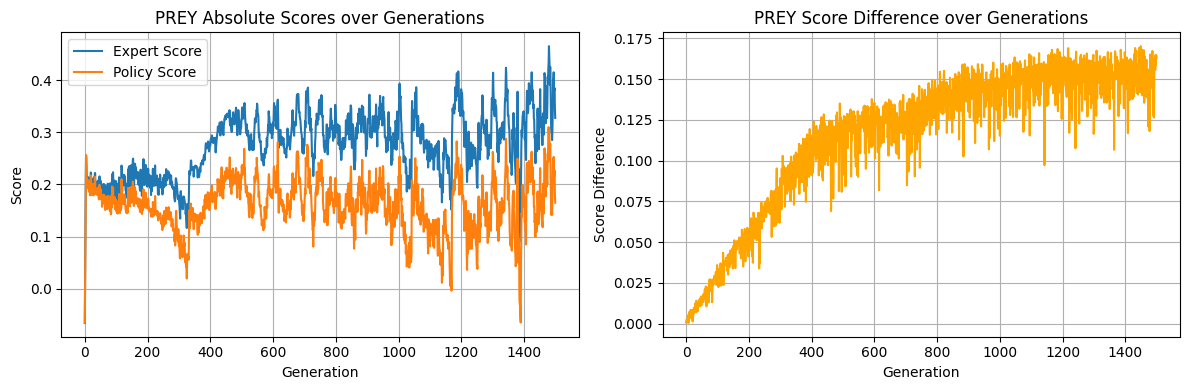

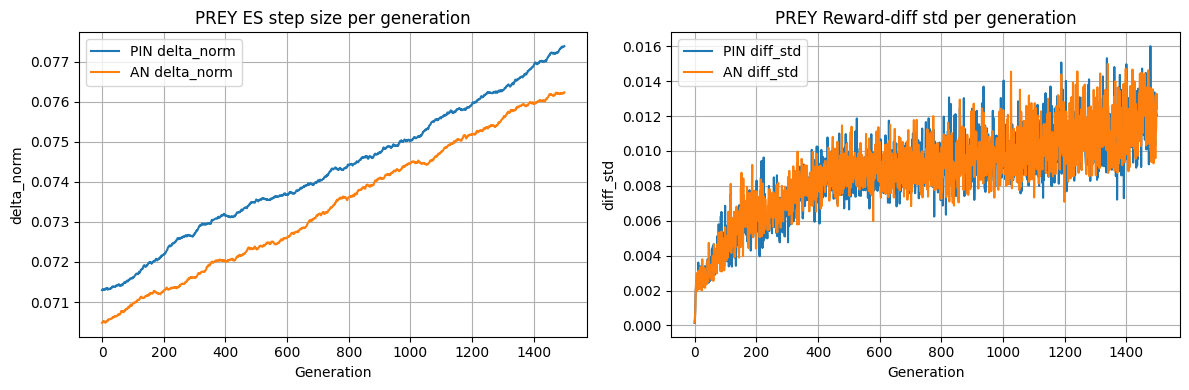

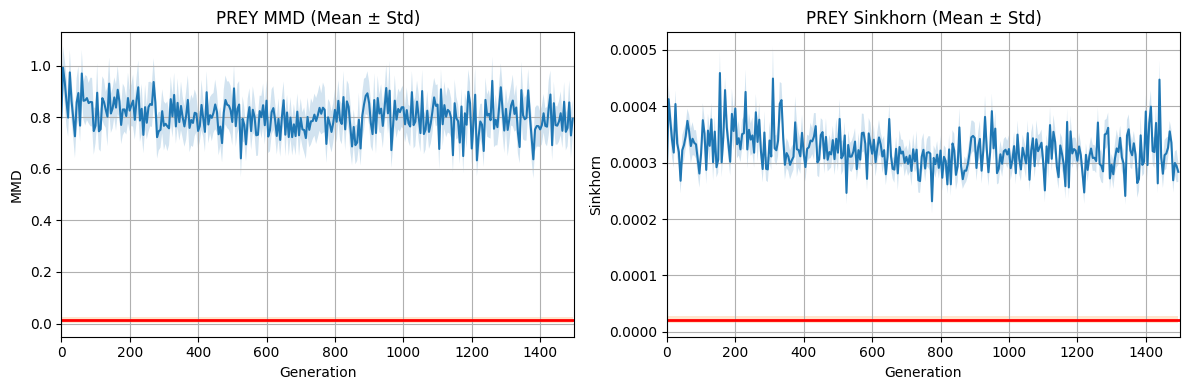

In [ ]:
%matplotlib inline
plot_train_metrics(disc_metrics_list, dis_balance_factor, role="prey", save_dir=run_dir)
plot_es_metrics(policy_metrics_list, role="prey", save_dir=run_dir)
plot_eval_metrics(metrics_list, role="prey", 
                  mmd_means=mmd_means, mmd_stds=mmd_stds, 
                  sinkhorn_means=sinkhorn_means, sinkhorn_stds=sinkhorn_stds, 
                  max_steps=num_generations, save_dir=run_dir)

In [ ]:
folder = "2026.01.12_00.13"
base_dir = Path(r"..\data\2. Training\training\PreyOnly - GAIL")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prey_path = base_dir / folder / "prey_only_policy.pth"
prey_policy = ModularPolicy(features=4).to(device)
prey_policy.load_state_dict(torch.load(prey_path, map_location=device))

<All keys matched successfully>

In [ ]:
%matplotlib tk
_, gen_prey_tensor, _ = run_env_simulation(visualization='on', 
                                            prey_policy=prey_policy, pred_policy=None,
                                            n_prey=32, n_pred=0, 
                                            max_steps=100,
                                            pred_speed=pred_speed, prey_speed=prey_speed,
                                            area_width=width, area_height=height,
                                            max_turn = max_turn,
                                            step_size=step_size)

In [ ]:
%matplotlib tk
_, exp_prey_sequence, couzin_metrics, actions, init_pool = run_couzin_simulation(
                                        visualization="on", 
                                        max_steps=100, 
                                         constant_speed=prey_speed, shark_speed=pred_speed, 
                                         area_width=width, area_height=height,
                                         dt = step_size,
                                         alpha=0.01,
                                         theta_dot_max=theta_dot_max, theta_dot_max_shark=theta_dot_max,
                                         number_of_sharks=0, n=32)

Min: 0.32793131470680237
Max: 0.6688212752342224
Mean: 0.4916729928740417


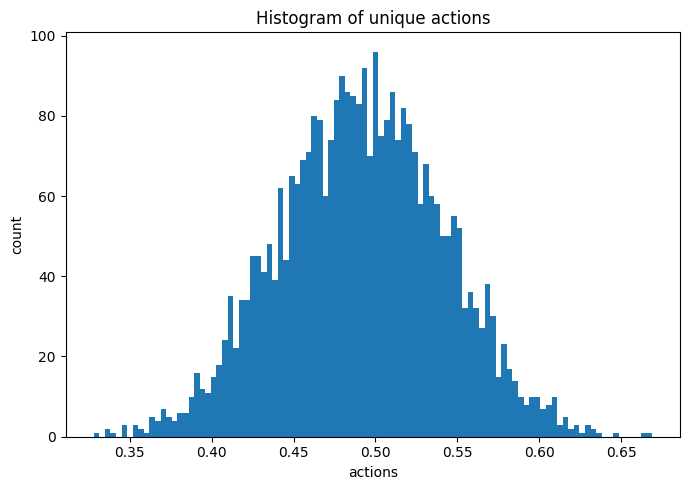

In [ ]:
%matplotlib inline
actions = gen_prey_tensor[..., 4]
actions_unique = list(set(actions.reshape(-1).tolist()))

print("Min:", min(actions_unique))
print("Max:", max(actions_unique))
print("Mean:", sum(actions_unique)/len(actions_unique))

plt.figure(figsize=(7,5))
plt.hist(actions_unique, bins=100)
plt.xlabel("actions")
plt.ylabel("count")
plt.title("Histogram of unique actions")
plt.tight_layout()
plt.show()